# Reading and editing a topography
A topograph/bathymetry is needed to create the domain of interpolation (land-sea mask). The topography/bathymetry is usually extracted from a netCDF file.     
Adapted topographies:
* General Bathymetric Chart of the Oceans ([GEBCO](https://www.gebco.net/))
* [EMODnet Bathymetry](http://www.emodnet-bathymetry.eu)
* Other topographies can be used as long as they define the netCDF variables `lon`, `lat` and `bat` (positive above sea-level and negative below, in `DIVAnd` however, the convention is that `z` is positive in sea water).

This notebook illustrates how the land-sea mask can be modified, for example to exclude a lake.


![mask](./Images/2020-01-12-more-prime-images-1.png)

This 7500 digits long number in binary is actually a prime number ([Gilles Esposito-Farèse](http://www.gef.free.fr/oulipo34.html#date060120)).

In [1]:
using DIVAnd
using PyPlot
using Dates
using Statistics

┌ Info: Precompiling DIVAnd [efc8151c-67de-5a8f-9a35-d8f54746ae9d]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


The full EMODnet Bathymetry is a quite big file (~1GB) that can be obtained from the bathymetry portal: http://portal.emodnet-bathymetry.eu/?menu=19. In the present notebook we will work with the GEBCO bathymetry with a resolution that has been decreased.

Note that an extremely fine bathymetry is not necessary when working on large domains.

## Data download and domain selection
We create a domain encompassing the north of Corsica.

In [2]:
dx = dy = 0.125
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

# https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download  gebco_30sec_4.nc
# https://dox.ulg.ac.be/index.php/s/wS6Y8P8NhIF60eG/download  gebco_30sec_8.nc
# https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download  gebco_30sec_16.nc
# https://dox.ulg.ac.be/index.php/s/pujUAyo9kTPO8oF/download  EMODNET Bathymetry

bathname = "../data/gebco_30sec_8.nc"

if !isfile(bathname)
    @info("Download bathymetry")
    download("https://dox.ulg.ac.be/index.php/s/wS6Y8P8NhIF60eG/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

bathisglobal = true;

┌ Info: Bathymetry file already downloaded
└ @ Main In[2]:16


We have two main tools to load the bathymetry:
1. `DIVAnd.extract_bath` loads the bathymetry at the resolution defined in the netCDF file while 
2. `DIVAnd.load_bath` reduces the resolution to match the resolution of the analysis.

### Extract bathymetry

In [3]:
?extract_bath

search: extract_bath



```
bx,by,b = DIVAnd.extract_bath(bath_name,isglobal,xi,yi)
```

Extract the bathymetry from the NetCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors defining the bounding box of the data. No interpolation is performed.

**Convention:** b is positive in the water and negative in the air.

The NetCDF file is expected to have the one dimensional variables `lon` and `lat` with the longitude (degrees East) and latitude (degrees North) and the two dimentional array `bat` with the digital terrain model (negative in water and positive above water). The order of the dimension should follow be: longitude and then latitude in [Column-major ordering](https://en.wikipedia.org/wiki/Row-_and_column-major_order) (or latitude and then longitude if the tool `ncdump` is used, which is based on Row-major ordering).

Example of the output of `ncdump -h`:

```
netcdf gebco_30sec_8 {
dimensions:
	lat = 2702 ;
	lon = 5400 ;
variables:
	double lat(lat) ;
		lat:long_name = "Latitude" ;
		lat:standard_name = "latitude" ;
		lat:units = "degrees_north" ;
	double lon(lon) ;
		lon:long_name = "Longitude" ;
		lon:standard_name = "longitude" ;
		lon:units = "degrees_east" ;
	float bat(lat, lon) ;
		bat:long_name = "elevation above sea level" ;
		bat:standard_name = "height" ;
		bat:units = "meters" ;

// global attributes:
		:title = "GEBCO" ;
}
```


In [4]:
bx,by,b = extract_bath(bathname,true,lonr,latr)
@show size(b);

size(b) = (148, 39)


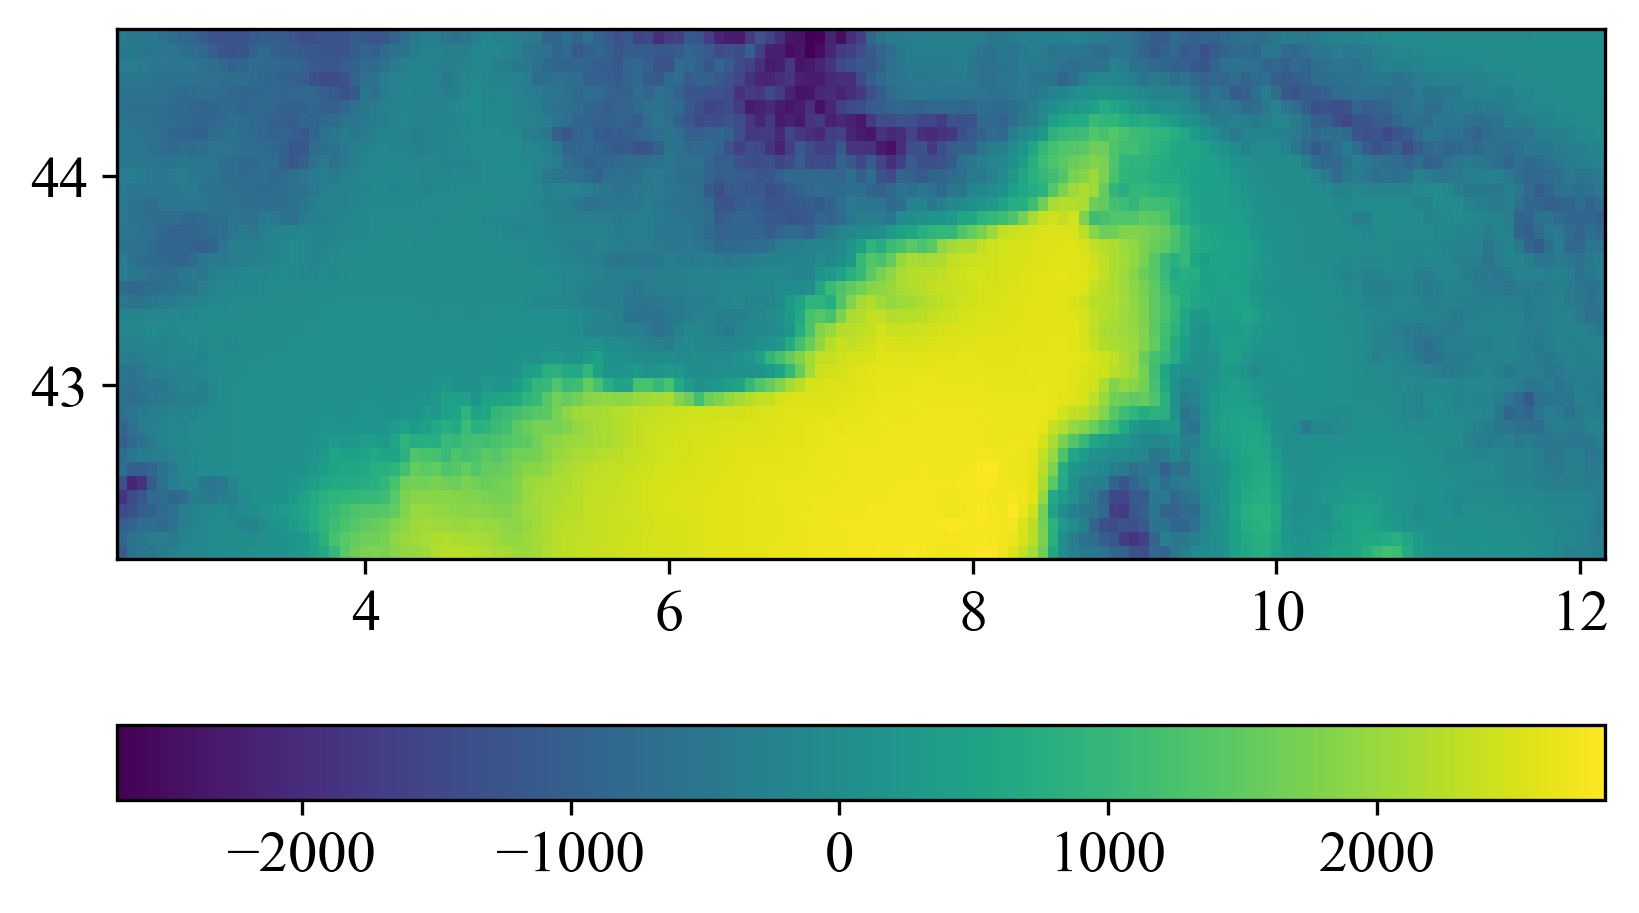

In [5]:
pcolor(bx, by, b'); 
colorbar(orientation="horizontal")
ax = gca()
ax.set_aspect(1/cos(mean([ylim()...]) * pi/180))

### Load bathymetry
With a change of its original resolution

In [6]:
?load_bath

search: load_bath



```
xi,yi,bath = DIVAnd.load_bath(bath_name,isglobal,xi,yi)
```

Load the bathymetry from the netCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors containing the longitude and latitude grid onto which the bathymetry should be interpolated.


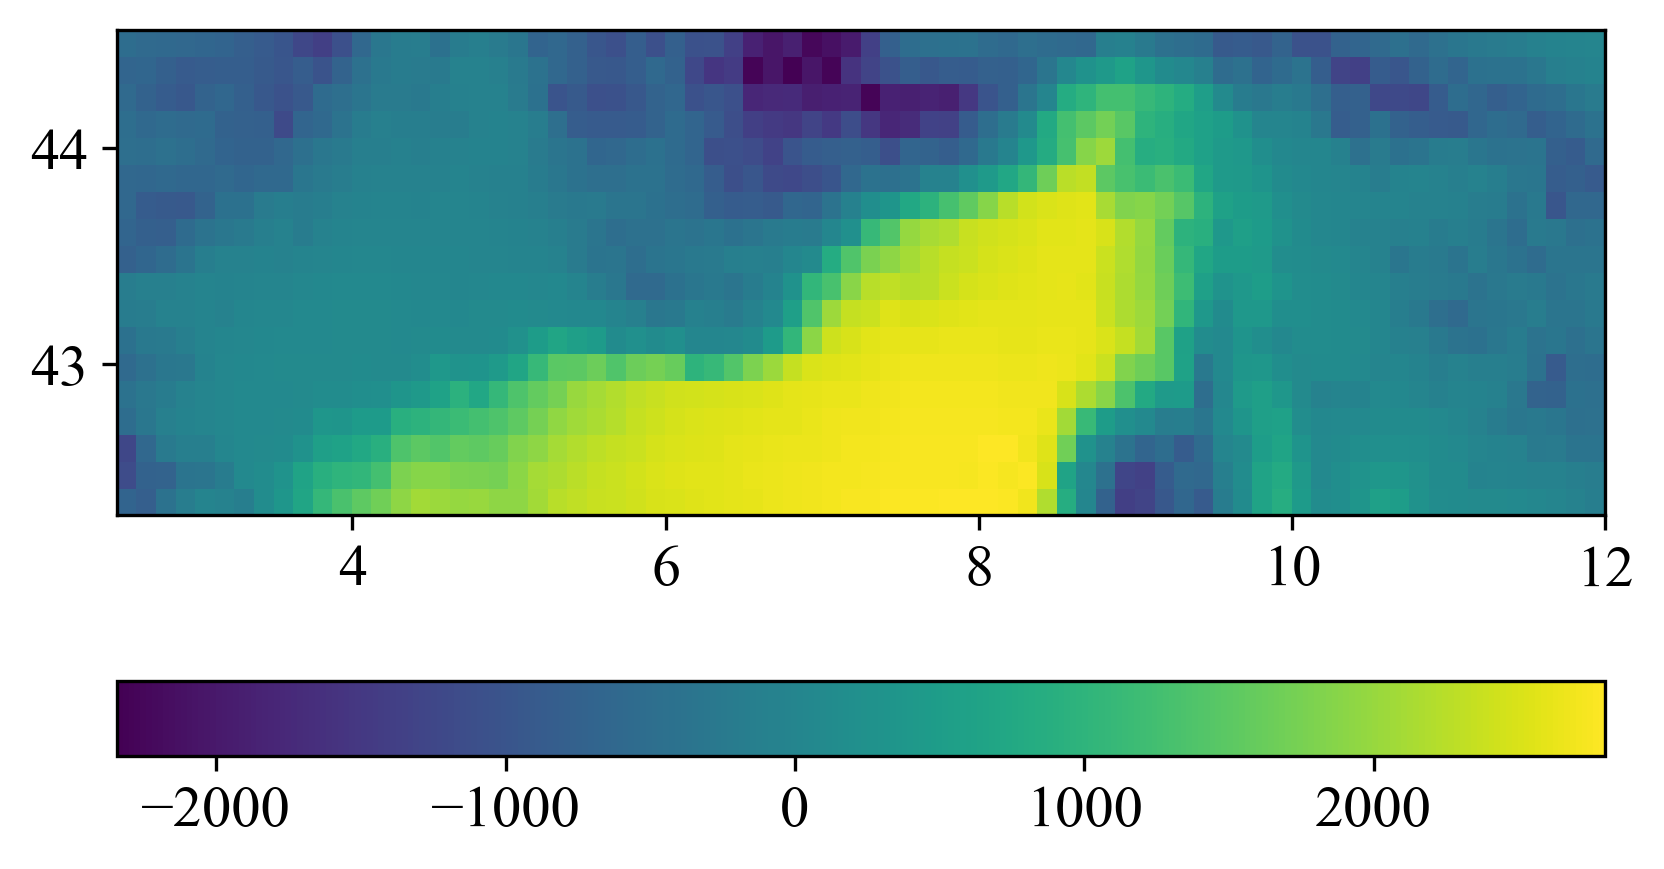

In [7]:
bx,by,b = load_bath(bathname,true,lonr,latr)

pcolor(bx,by,b'); 
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))

#@show size(b)

## Mask creation
We start by defining the mask as a 3D matrix containing only `False`, then we set the values to `True` when the actual depth is deeper than the selected values stored in the vector `depthr`.

In [8]:
pathof(DIVAnd)

"/home/ctroupin/.julia/packages/DIVAnd/rJCtr/src/DIVAnd.jl"

In [9]:
depthr = [0,10,20,500]
mask = falses(size(b,1),size(b,2),length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end
@show typeof(mask)

typeof(mask) = BitArray{3}


BitArray{3}

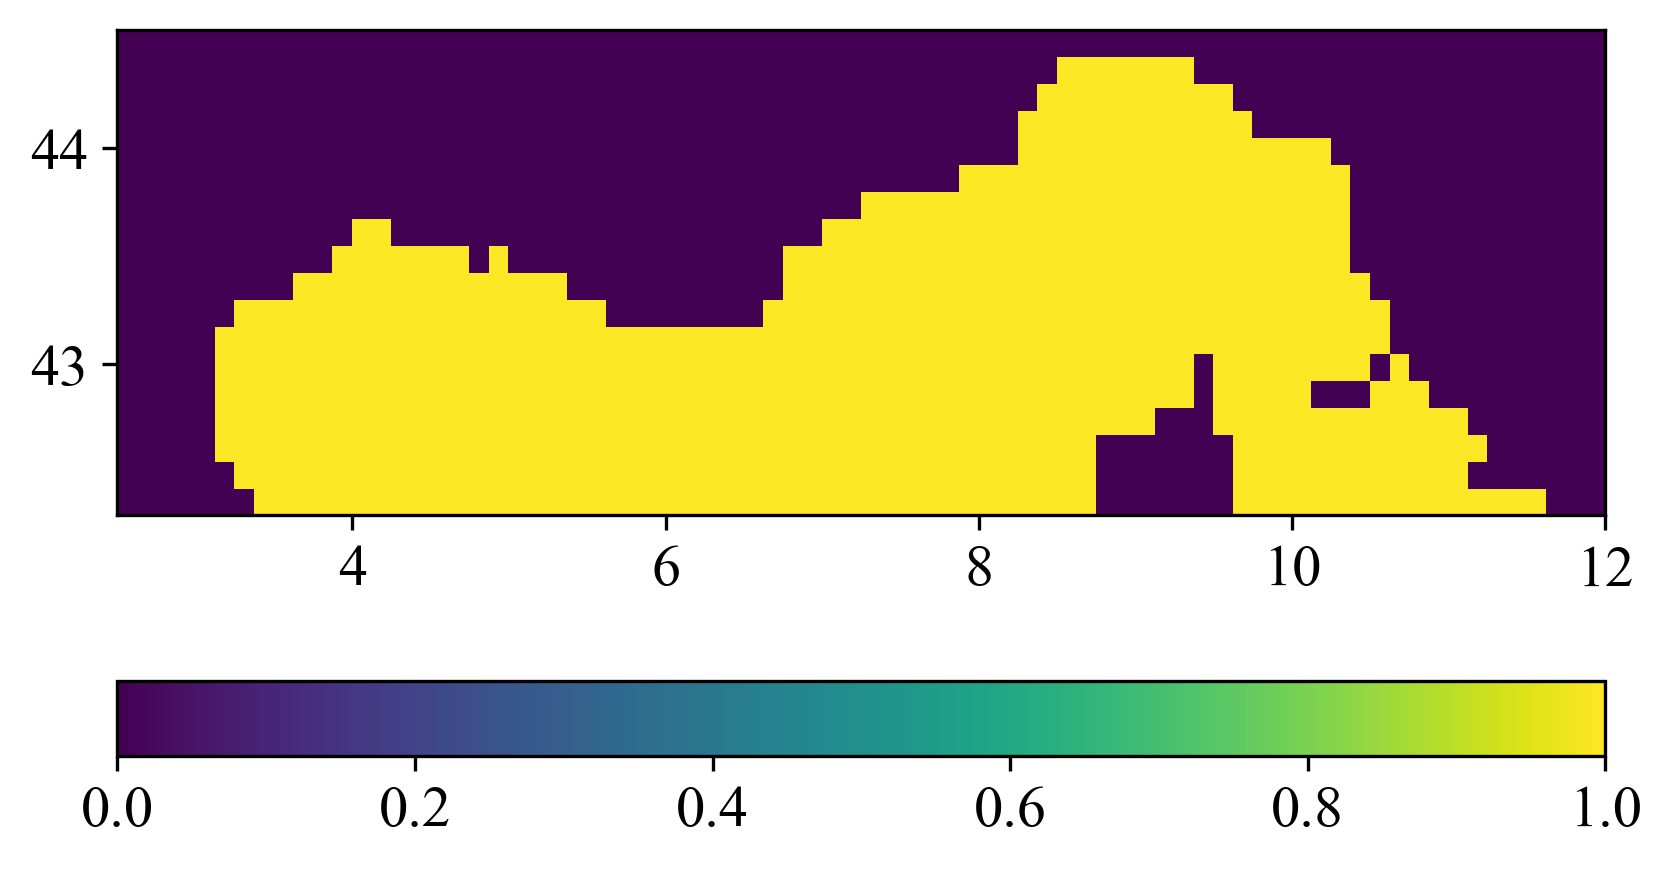

In [10]:
pcolor(bx,by,Float64.(mask[:,:,1]'))
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

Another solution is to use the `load_mask` function:

In [11]:
xmask,ymask,mmask = load_mask(bathname,true,lonr,latr,depthr);

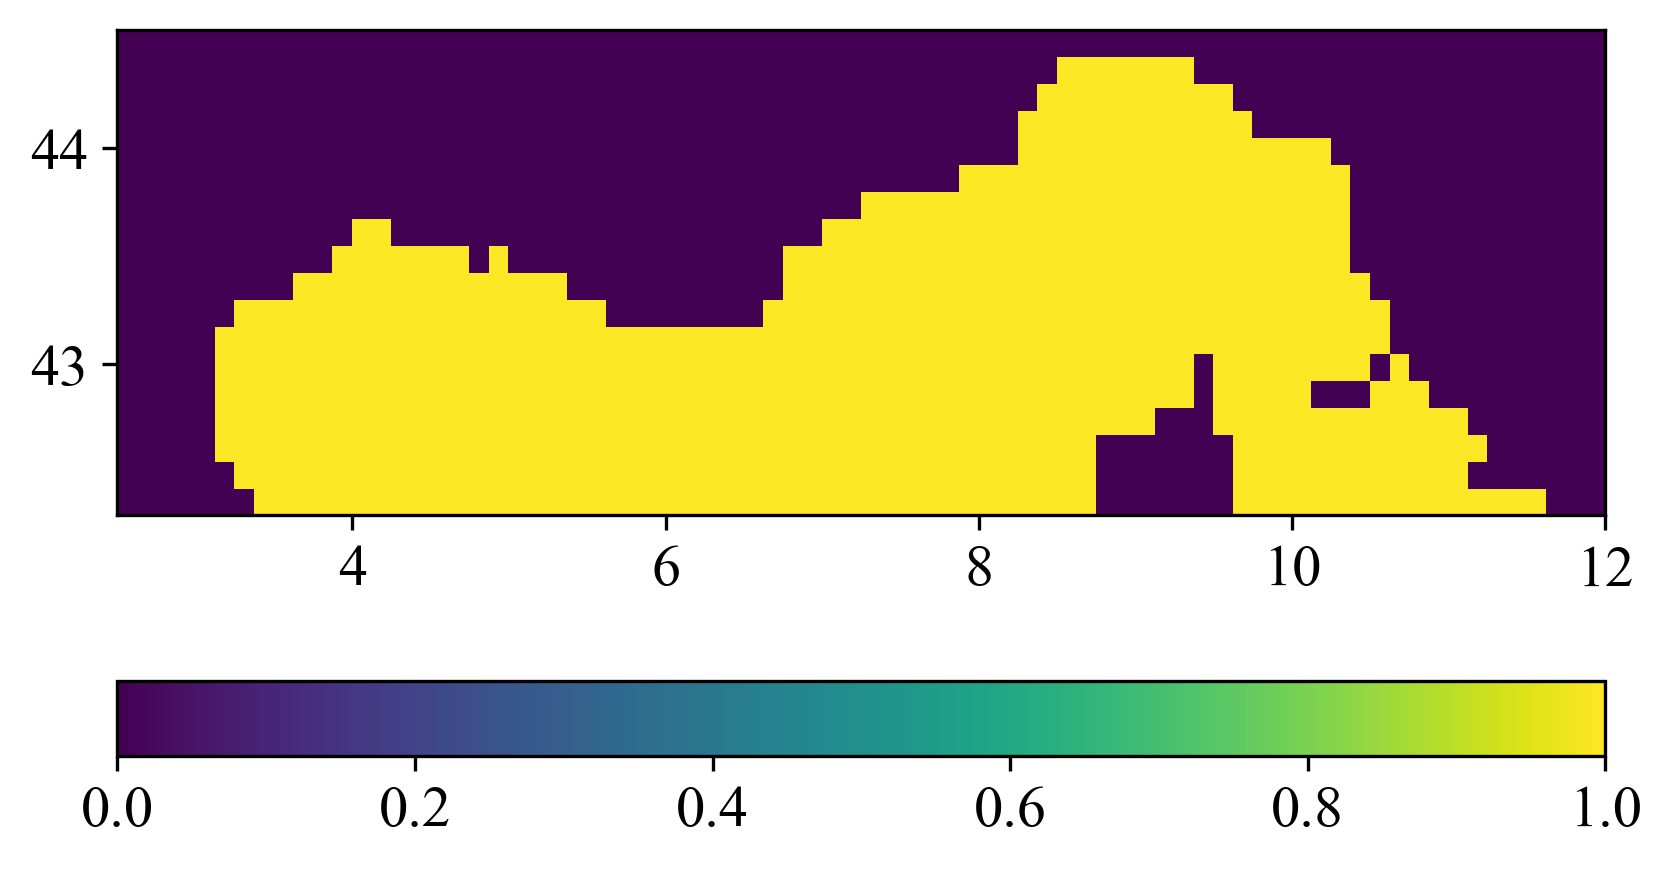

In [12]:
pcolor(xmask,ymask,Float64.(mask[:,:,1]'))
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

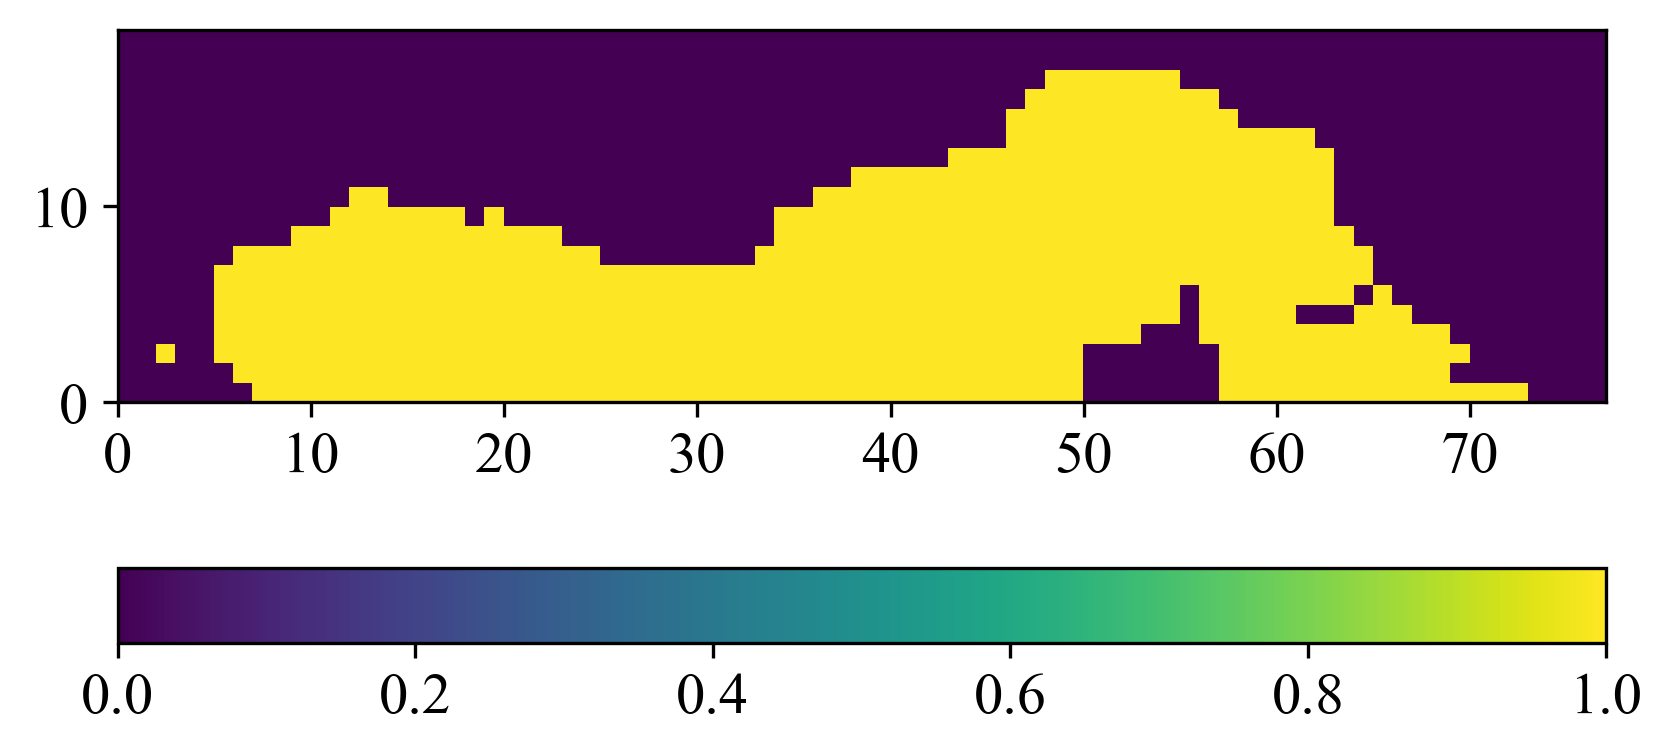

In [13]:
mask[3,3,1] = true
pcolor(Float64.(mask[:,:,1])')
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

In [14]:
?DIVAnd.floodfill

```
label = floodfill(mask)
```

Attribute an integer number (a numeric label) to every element in mask such that all grid points connected by a von Neumann neighborhood (without crossing elements which are `false` in mask) have the same label. Labels are sorted such that the label 1 corresponds to the largest area, label 2 the 2nd largest and so on.


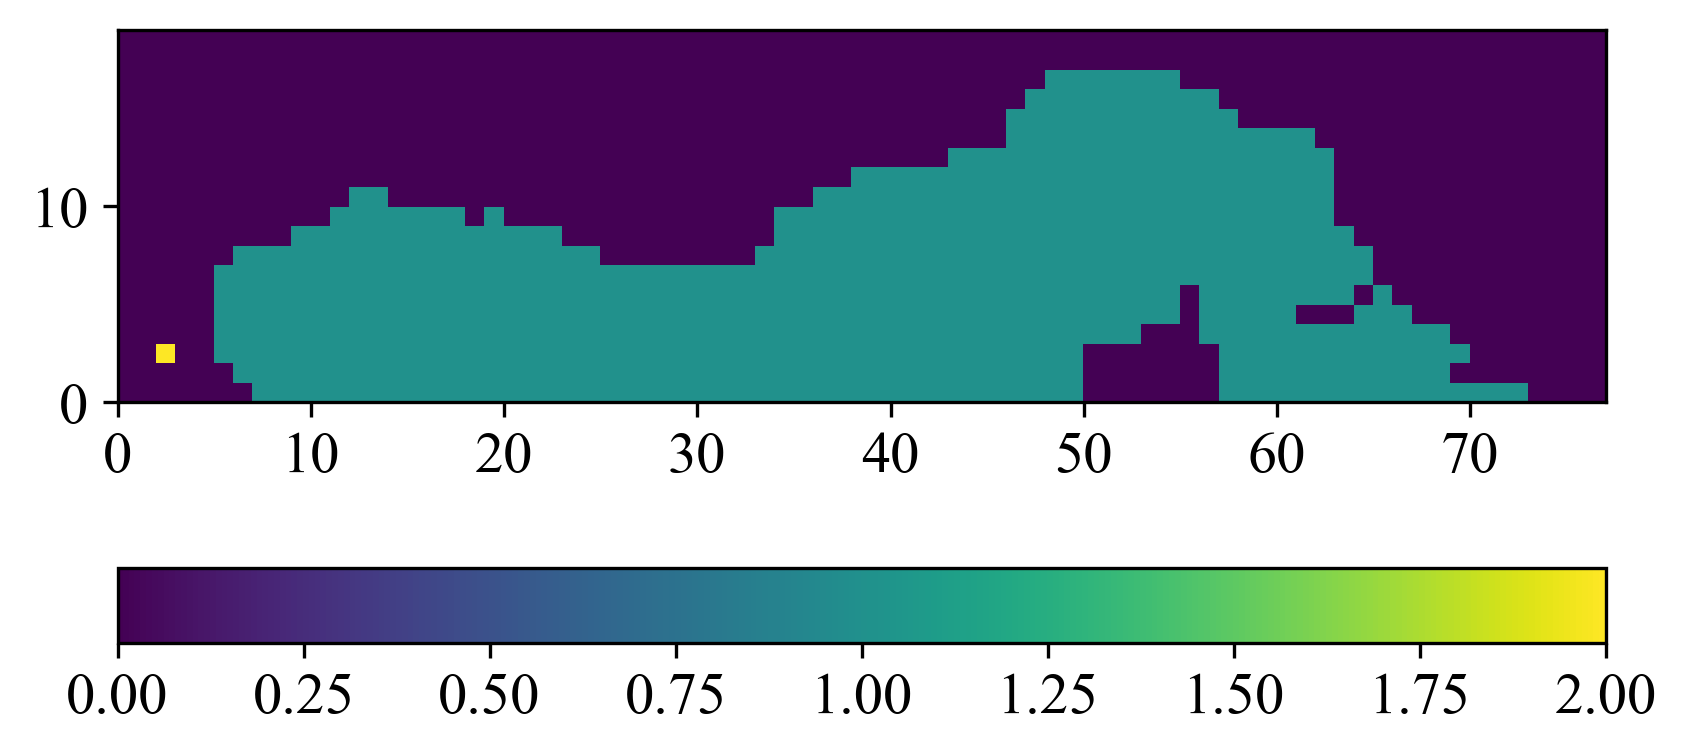

In [15]:
label = DIVAnd.floodfill(mask)
pcolor(label[:,:,1]')
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

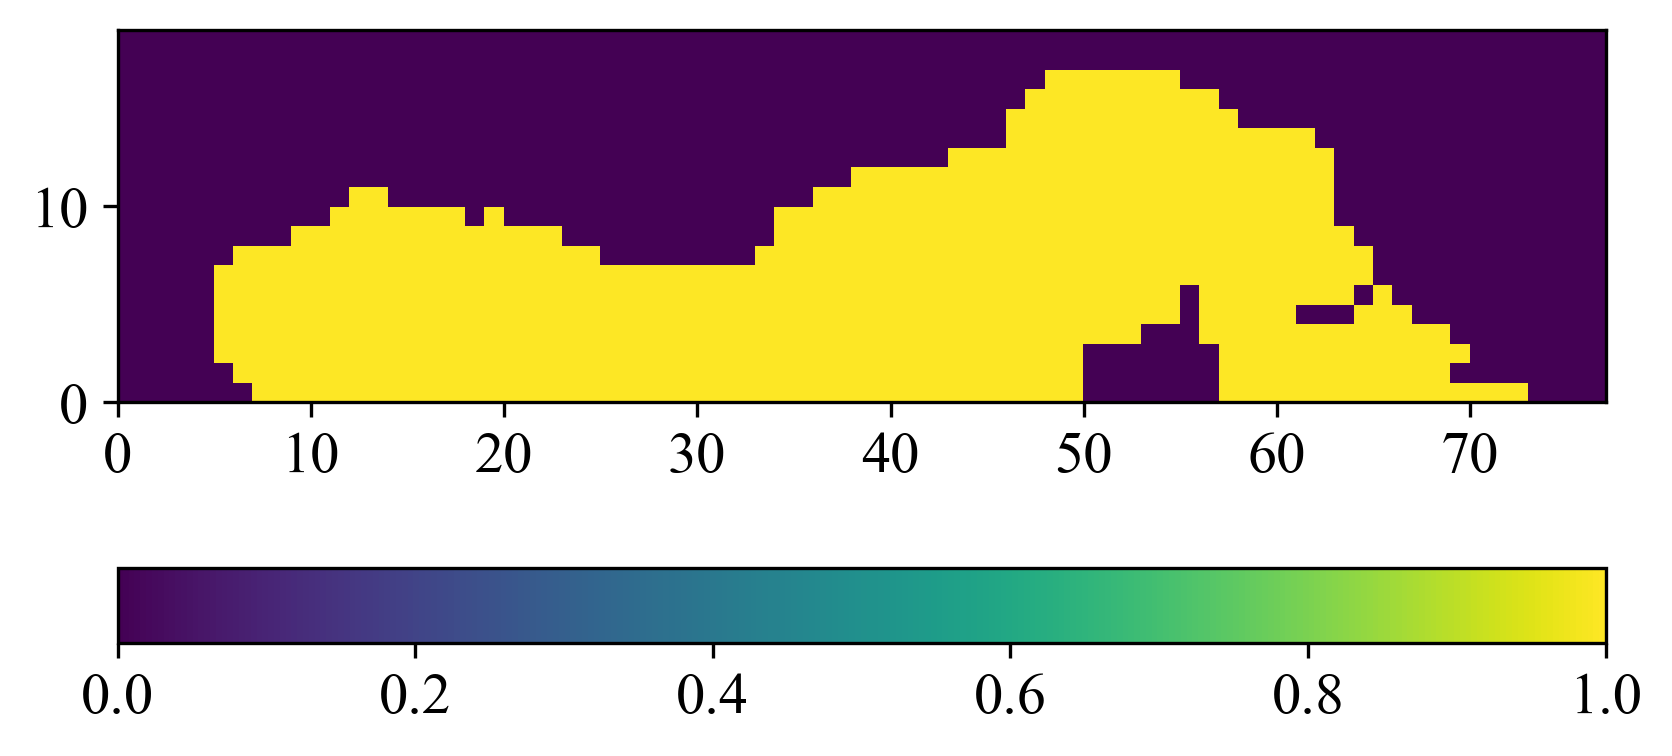

In [16]:
mask3 = label .== 1
pcolor(Float64.(mask3[:,:,1])')
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

## Mask editing
To edit the mask, you can either modify directly its value if you know the indices, or you can use a selection based on the coordinates.
### Create an artificial island
We simply modify the mask at a given location.

In [17]:
# Create a copy of the mask for ediding
mask_copy = copy(mask);
mask_copy[63,8,:] .= false;

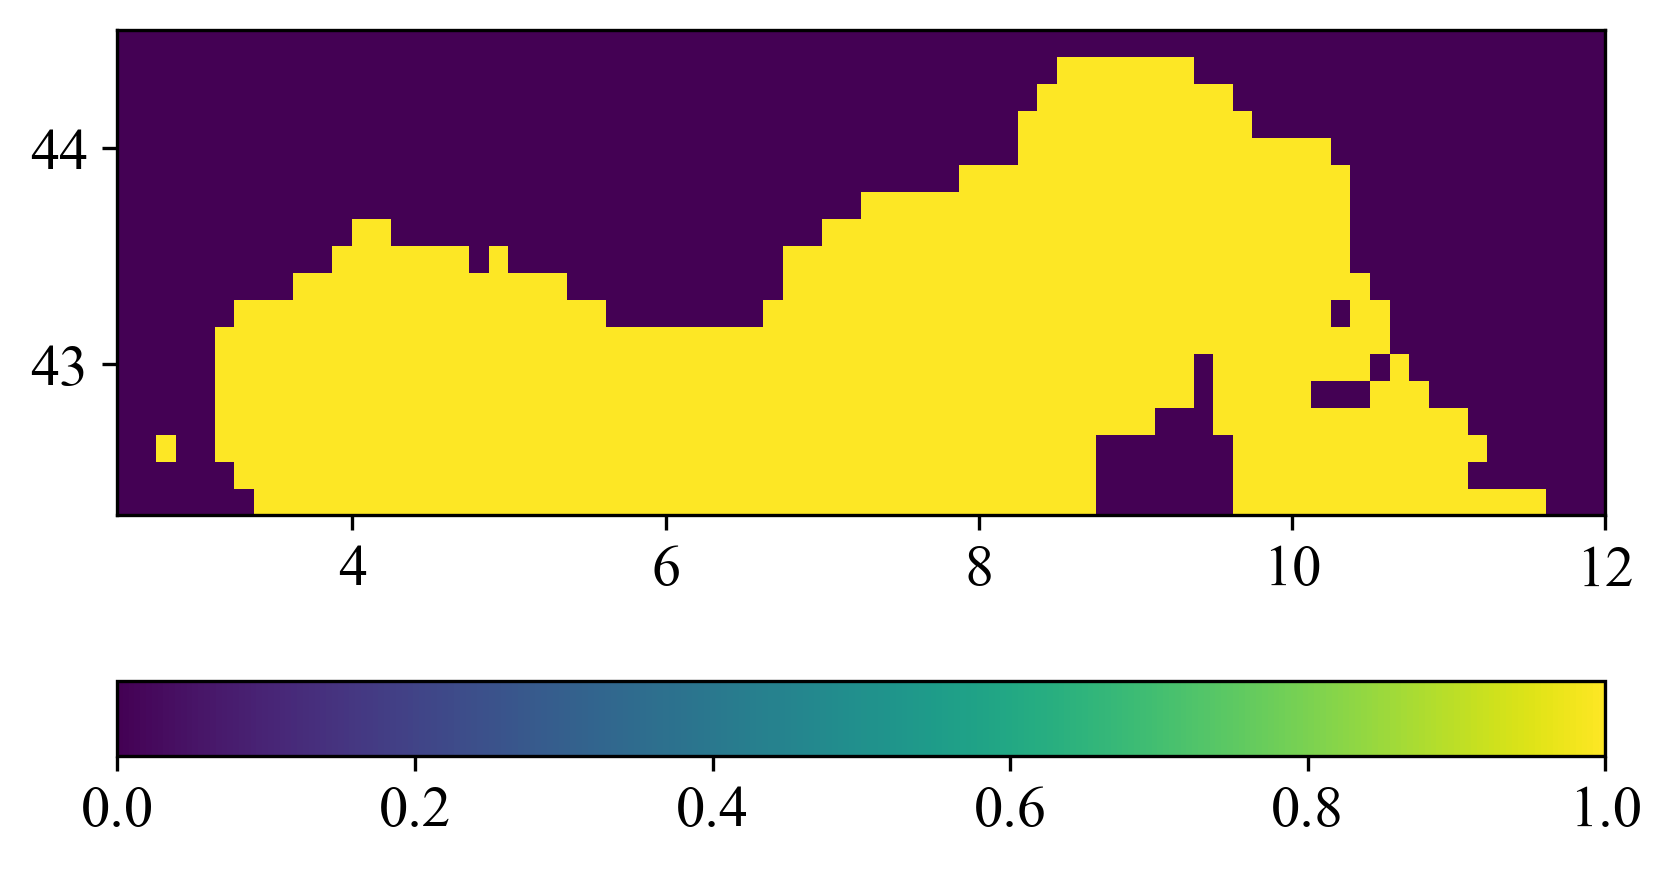

In [18]:
pcolor(bx, by, Float64.(mask_copy[:,:,1]'))
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))

### Remove an island (based on indices)

In [19]:
mask_copy = copy(mask);
mask_copy[48:59,1:10,:] .= true;

In [20]:
yl = (2,3)
mean(yl)

2.5

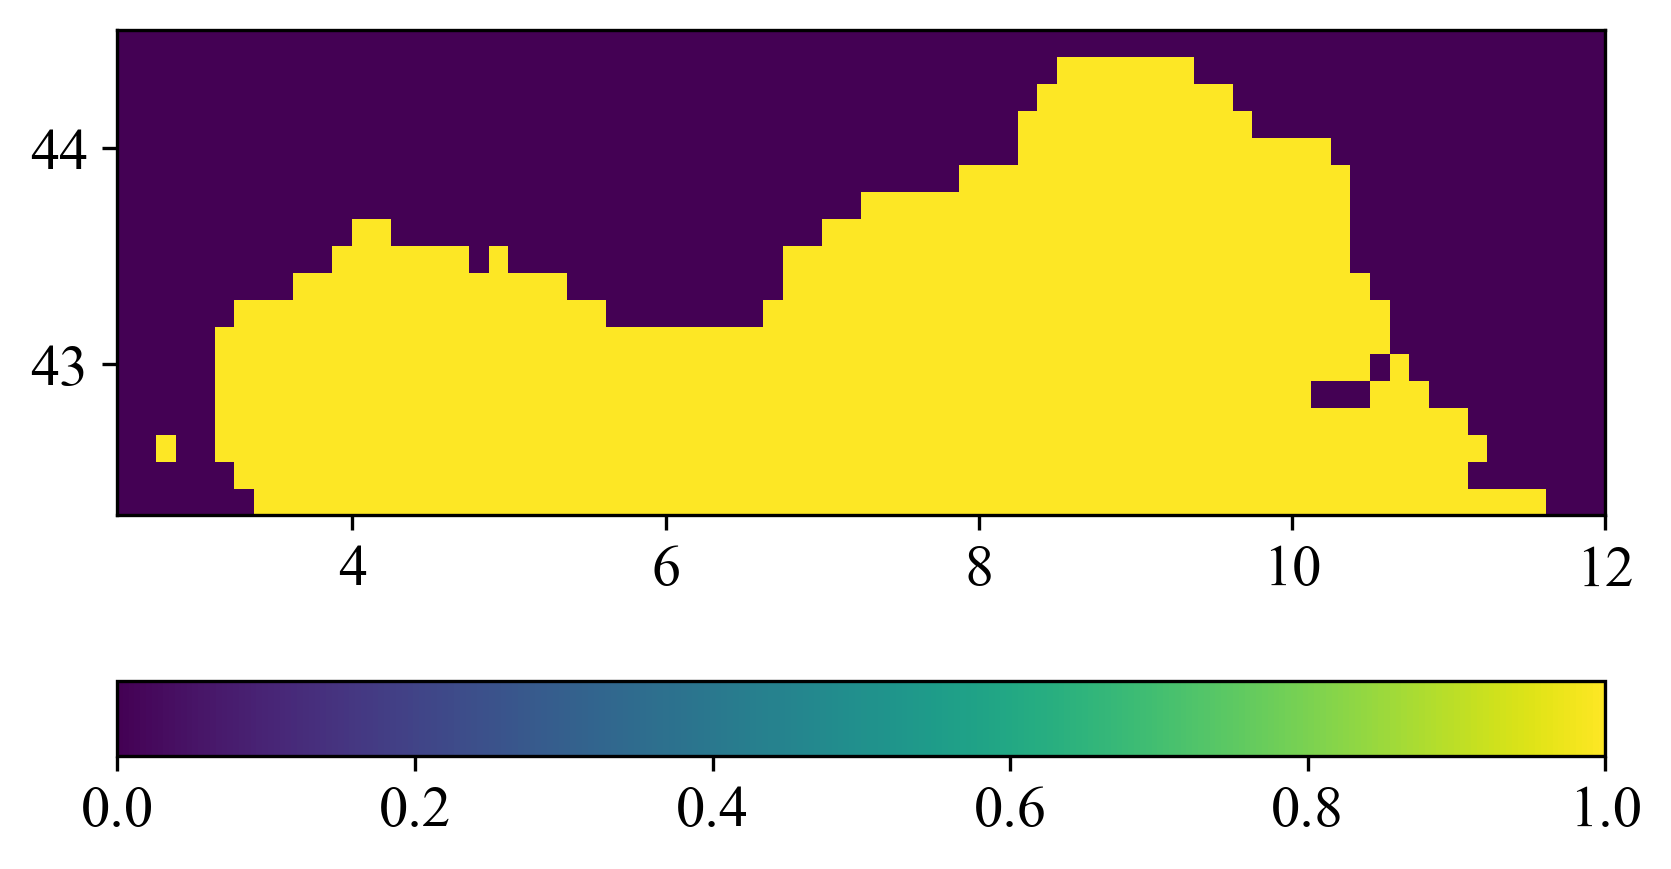

In [21]:
pcolor(bx, by, Float64.(mask_copy[:,:,1]'))
colorbar(orientation="horizontal")
gca().set_aspect(1/cosd(mean(ylim())))
#[ylim()...]

### Remove an island (based on coordinates). 

This is the recommended approach as you can change resolution easily
`sel_lon` and `sel_lat` are obtained by checking the longitude and latitudes.

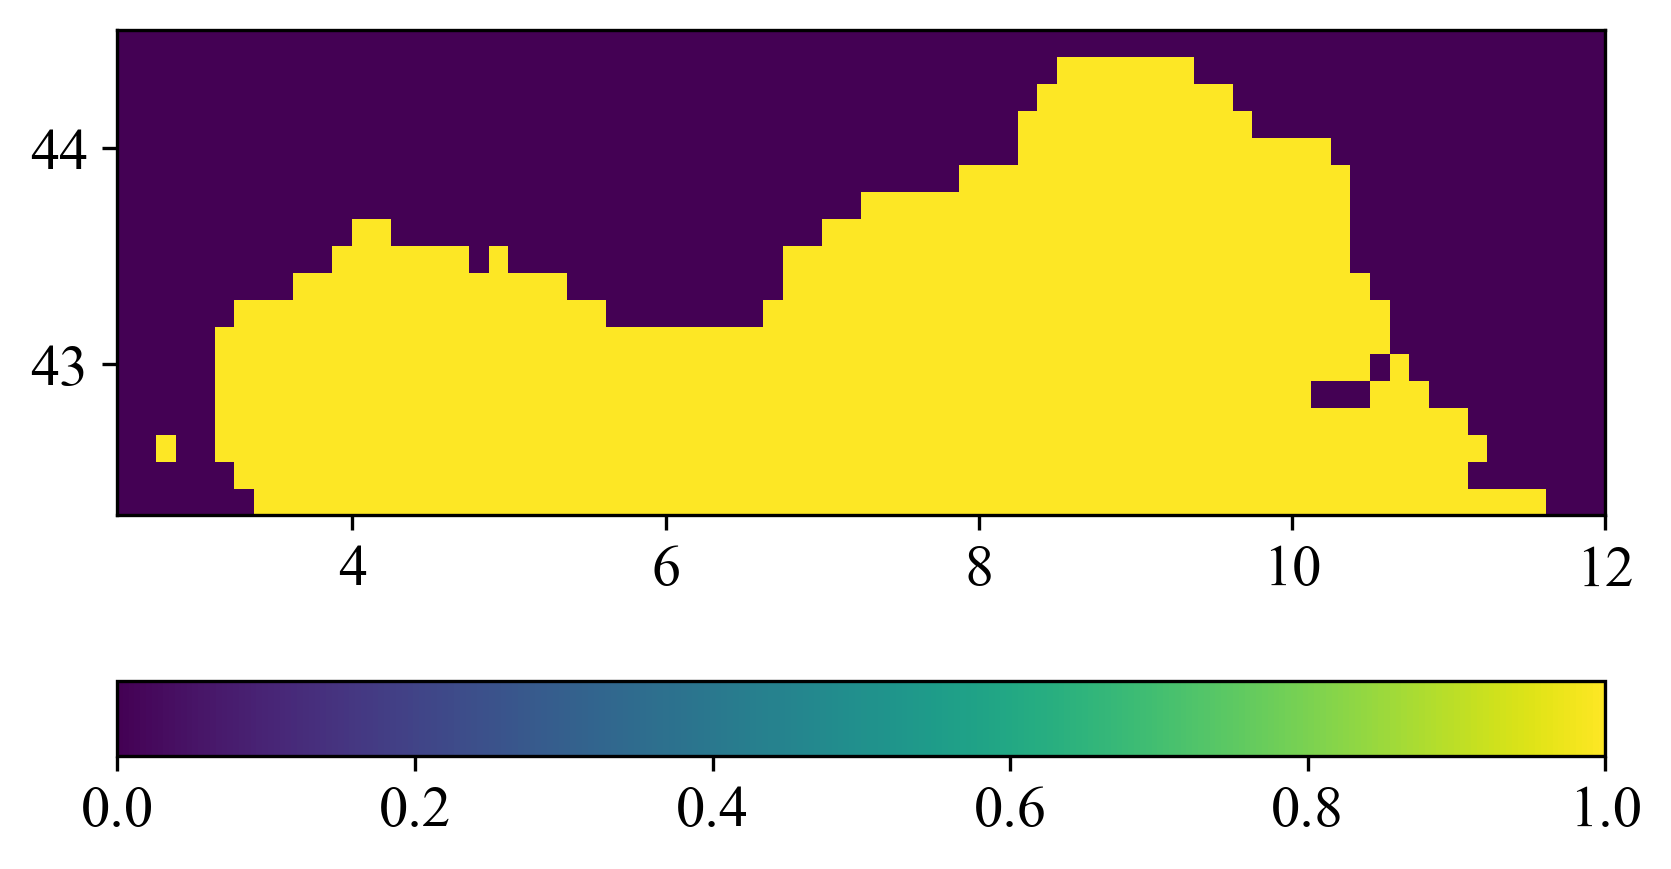

In [22]:
mask_copy = copy(mask);
sel_lon = (bx.>8) .& (bx.<10.);
sel_lat = (by.<43.25);
mask_copy[sel_lon, sel_lat, :] .= true;
pcolor(bx, by, Float64.(mask_copy[:,:,1]')); 
colorbar(orientation="horizontal")
gca().set_aspect(1/cos(mean([ylim()...]) * pi/180))

In [23]:
@show sel_lon;

sel_lon = Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## Exercice
1. Load the bathymetry around the Black Sea.
2. Create a land sea mask for the following levels: 0, 150, 500 and 1000 meters.
3. Remove the Sea of Azov and the Sea of Marmara.
4. Plot the result.

The solution is available in [06-topography-BlackSea](./solutions/06-topography-BlackSea.ipynb) and should look like this:

<img src="./Images/BlackSea_mask.png" width="250px">

# Adapt own bathymetry (advanced)

To use a local bathymetry, one needs to create a netCDF file which has a similar structure than GEBCO files.
In particular, the netCDF file is expected to have the one dimensional variables `lon` and `lat` with the longitude (degrees East) and latitude (degrees North) and the two dimentional array `bat` with the digital terrain model (negative in water and positive above water). The order of the dimension should follow be: longitude and then latitude in Column-major ordering (or latitude and then longitude if the tool ncdump is used, which is based on Row-major ordering).

The module `NCDatasets`, provide the utility function `ncgen` which returns the Julia code that creates a netCDF file with the same metadata:

In [24]:
using NCDatasets
ncgen(bathname)

ds = Dataset("filename.nc","c")
# Dimensions

ds.dim["lat"] = 2702
ds.dim["lon"] = 5400

# Declare variables

nclat = defVar(ds,"lat", Float64, ("lat",))
nclat.attrib["long_name"] = "Latitude"
nclat.attrib["standard_name"] = "latitude"
nclat.attrib["units"] = "degrees_north"

nclon = defVar(ds,"lon", Float64, ("lon",))
nclon.attrib["long_name"] = "Longitude"
nclon.attrib["standard_name"] = "longitude"
nclon.attrib["units"] = "degrees_east"

ncbat = defVar(ds,"bat", Float32, ("lon", "lat"))
ncbat.attrib["long_name"] = "elevation above sea level"
ncbat.attrib["standard_name"] = "height"
ncbat.attrib["units"] = "meters"

# Global attributes

ds.attrib["title"] = "GEBCO"

# Define variables

# nclat[:] = ...
# nclon[:] = ...
# ncbat[:] = ...

close(ds)


In this example, one would need to adapt:
* the title attribute of the NetCDF file 
* the size of the dimensions
* define the variables `nclon`, `nclat` and `ncbat`